# Финальный проект, вариант 2

## Задание 1. A/B–тестирование

#### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

#### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

In [66]:
# Загрузка необходимых библиотек

import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as ss

import pandahouse as ph

### Загрузка файлов

Файлы загружаю с jupyterhub, т.к. ссылки на яндекс во время выполнения проекта были частично или полностью недоступны

In [67]:
# Информация о принадлежности пользователя к контрольной или экспериментальной (тестовой) группе.

groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [68]:
# Дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных.

groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_group_add.csv')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [69]:
# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_active_studs.csv', sep=';')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [70]:
# Информация об оплатах пользователей в дни проведения эксперимента.

checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### EDA и предподготовка данных: проверка информации о содержимом файлов, наличия пропущенных и количества уникальных значений, описательной статистики

In [71]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [72]:
groups.nunique()

id     74484
grp        2
dtype: int64

Все значения id уникальны, разделены на две группы, пропущенных значений нет

In [73]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

O_o В самом начале исследования нас ждёт интересная особенность данных - количество уникальных пользователей в тестовой группе в 4 раза превышает аналогичный показатель в контрольной группе и это очень странно, целесообразность распространения нововведения на бОльшую часть аудитории вызывает сомнения, обычно организаторы эксперимента поступают наоборот. В связи с этим возникает предположение о вероятной некорректности формирования выборок...

Посмотрим на дополнительный файл с пользователями

In [74]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [75]:
groups_add.nunique()

id     92
grp     2
dtype: int64

Здесь так же - все значения id уникальны, разделены на две группы, пропущенных значений нет

In [76]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

Пропорции распределения пользователей по группам примерно те же

Сразу объединим датафреймы groups и groups_add

In [77]:
groups_df = pd.concat([groups, groups_add])

In [78]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [79]:
groups_df.nunique()

id     74576
grp        2
dtype: int64

In [80]:
groups_df.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Все значения id уникальны, разделены на две группы, пропущенных значений нет

Посмотрим на данные о пользователях, посетивших платформу в дни проведения эксперимента

In [81]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [82]:
active_studs.nunique()

student_id    8341
dtype: int64

В дни проведения эксперимента на платформу зашёл 8341 уникальный пользователь, добавим к этим данным датафрейм с информацией о группах, предварительно переименовав 'student_id' в 'id'

In [83]:
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [84]:
# Используем left join, чтобы сохранить только активных пользователей

studs = active_studs.merge(groups_df, how='left', on='id')\
                    .rename(columns={'grp': 'group'})
studs

,id,group
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [85]:
studs.group.value_counts()

B    6803
A    1538
Name: group, dtype: int64

Соотношение количества пользователей в группах практически не изменилось

Посмотрим на информацию об оплатах

In [86]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [87]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [88]:
checks.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
2910.0000     4
2890.0000     4
1980.0000     4
2099.0000     3
489.0000      3
1160.0000     3
1180.0000     2
2220.0000     2
2820.0000     2
597.0000      1
1388.0000     1
3260.0000     1
880.0000      1
3040.0000     1
796.0000      1
1968.0000     1
1339.0000     1
4650.0000     1
2900.0000     1
630.0000      1
1830.0000     1
1039.0000     1
1050.0000     1
1729.0000     1
2190.0000     1
Name: rev, dtype: int64

In [89]:
checks.rev.sum()

573326.0035999999

541 пользователь произвёл оплату на 38 различных сумм (оплаты на 1900 и 1900.0001 будем считать одинаковыми, возможно это ошибка или особенность логирования). Каждый пользователь совершил одну покупку, все значения id уникальны, пропущенных значений нет. Около четверти всех значений (541/133=4.07) оказалось на сумму в 1900. Любопытно, что и соотношение количества пользователей в группах тоже равно 4.07, возможно в этом есть какой-то тайный смысл...

Посмотрим на описательную статистику по колонке 'rev' и построим гистограмму распределения значений

In [90]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

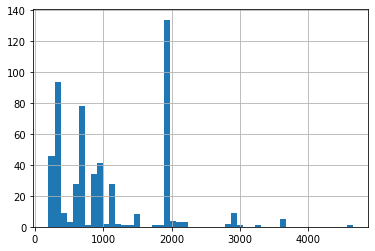

In [91]:
checks.rev.hist(bins=50)

Объединим таблицы, так же предварительно переименовав 'student_id' в 'id' и создав колонку с данными об оплате - заплатившим пользователям присвоим значение 'pay', а не заплатившим - 'no_pay' 

In [92]:
checks = checks.rename(columns={'student_id': 'id'})

In [93]:
data = studs.merge(checks, how='left', on='id')\
            .rename(columns={'rev': 'revenue'})\
            .fillna(0)
data['payment_info'] = data.revenue.apply(lambda x: 'pay' if x > 0 else 'no_pay')    
data

,id,group,revenue,payment_info
0,581585,A,0.0,no_pay
1,5723133,A,0.0,no_pay
2,3276743,B,0.0,no_pay
3,4238589,A,0.0,no_pay
4,4475369,B,0.0,no_pay
...,...,...,...,...
8336,1794344,B,0.0,no_pay
8337,296883,B,0.0,no_pay
8338,3598448,B,0.0,no_pay
8339,3610547,B,290.0,pay


Проверим количество пользователей, совершивших оплату

In [94]:
data.groupby('payment_info')\
    .agg({'revenue': 'count'})

,revenue
payment_info,
no_pay,7949
pay,392


В итоговом датафрейме содержится информация только о 392 пользователях, оплативших что-то на платформе в дни проведения эксперимента, хотя всего оплативших 541. То есть, 149 из активных пользователей не заходили на платформу во время проведения эксперимента, но при этом совершили оплату. Возможно, это значит, что у них есть какая-либо подписка и списание произошло автоматически. 
В расчёте не будем учитывать эти 149 пользователей - они не заходили на платформу, следовательно не участвовали в эксперименте.

Посмотрим какой процент из активных пользователей совершили покупку

In [95]:
CR = data.loc[data.payment_info == 'pay']\
         .groupby('payment_info', as_index=False)\
         .agg({'revenue': 'count'})\
         .rename(columns={'revenue': 'paying_users'})
CR['CR'] = ((CR.paying_users / data.id.nunique()) * 100).round(2)
CR

,payment_info,paying_users,CR
0,pay,392,4.7


Соответственно, 4.7% - это средняя конверсия в покупку по обеим группам

Рассмотрим более подробно каждую из групп

In [96]:
group_a = data.loc[data.group == 'A']

In [97]:
group_a.nunique()

id              1538
group              1
revenue           24
payment_info       2
dtype: int64

In [98]:
hist_data_a = group_a.loc[group_a.revenue > 0]\
                     .groupby('revenue', as_index=False)\
                     .agg({'id': 'count'})                  

In [99]:
fig = px.histogram(hist_data_a,
                   x = 'revenue',
                   y = 'id',
                   color = 'id',        
                   nbins = 70,  
                   range_x = [0, 3800],
                   title = 'Distribution of users quantity by revenue sum, group A',
                   height = 600, width = 900)
fig.show()

Распределение не похоже на нормальное

In [100]:
group_b = data.loc[data.group == 'B']

In [101]:
group_b.nunique()

id              6803
group              1
revenue           34
payment_info       2
dtype: int64

In [102]:
hist_data_b = group_b.loc[group_b.revenue > 0]\
                     .groupby('revenue', as_index=False)\
                     .agg({'id': 'count'})   

In [123]:
fig = px.histogram(hist_data_b,
                   x = 'revenue',
                   y = 'id',
                   color = 'id',        
                   nbins = 210,  
                   range_x = [0, 3800],
                   title = 'Distribution of users quantity by revenue sum, group B',
                   height = 600, width = 900)
fig.show()

Распределение так же не похоже на нормальное, с этим разберёмся далее. 

В тестовой группе количество покупок на сумму 1900 значительно превышает аналогичные показатели для других сумм. Но особенно примечательно то, что покупки на данную сумму совершались только представителями тестовой группы, в контрольной таких значений нет. К тому же, данная аномалия, скорее всего, не могла быть вызвана изменениями на этапе оплаты. Вероятно, параллельно с введением "новой механики оплаты" маркетологи предложили организаторам эксперимента заодно провести промо акцию с большой скидкой на определённый товар. Это выглядит даже более странным, чем неравномерность распределения по группам, думаю, что в работе уже на данном этапе я бы перестал анализировать успешность эксперимента до выяснения подробностей. Однако, вряд ли смысл данного задания в проверке корректности проведения А/В теста, поэтому продолжим.

Теперь определимся с выбором метрик. Если исследуется поведение пользователя на этапе оплаты, то нас прежде всего интересует конверсия в покупку. Сделать однозначный вывод о том, что подразумевает "новая механика оплаты" не получится, поэтому предположим, что представителям тестовой группы оплатить что-либо на платформе стало удобнее или проще и, соответственно, по логике эксперимента, конверсия в покупку для тестовой группы должна вырасти. Также рассмотрим ARPU и ARPPU, эти метрики важны для оценки динамики дохода. 

#### Посчитаем конверсию в покупку (CR) для каждой из групп

In [104]:
CR_A = group_a.loc[group_a.payment_info == 'pay']\
              .groupby(['group', 'payment_info'], as_index=False)\
              .agg({'revenue': 'count'})\
              .rename(columns={'revenue': 'paying_users'})
CR_A['CR'] = ((CR_A.paying_users / group_a.id.nunique()) * 100).round(2)
CR_A

,group,payment_info,paying_users,CR
0,A,pay,78,5.07


In [105]:
CR_B = group_b.loc[group_b.payment_info == 'pay']\
              .groupby(['group', 'payment_info'], as_index=False)\
              .agg({'revenue': 'count'})\
              .rename(columns={'revenue': 'paying_users'})
CR_B['CR'] = ((CR_B.paying_users / group_b.id.nunique()) * 100).round(2)
CR_B

,group,payment_info,paying_users,CR
0,B,pay,314,4.62


Значение CR в тестовой группе ниже, чем в контрольной и это нехорошо, т.к. снижение основной метрики во многом говорит о нецелесообразности нововведения.

#### Посчитаем ARPU для каждой из групп

In [106]:
ARPU_A = group_a.groupby('group', as_index=False)\
                .agg({'id': 'count', 'revenue': 'sum'})
ARPU_A['ARPU'] = (ARPU_A.revenue / ARPU_A.id).round(2)
ARPU_A

,group,id,revenue,ARPU
0,A,1538,72820.0,47.35


In [107]:
ARPU_B = group_b.groupby('group', as_index=False)\
                .agg({'id': 'count', 'revenue': 'sum'})
ARPU_B['ARPU'] = (ARPU_B.revenue / ARPU_B.id).round(2)
ARPU_B

,group,id,revenue,ARPU
0,B,6803,394974.0035,58.06


Значение ARPU в тестовой группе выше, чем в контрольной. Предполагаю, что данный эффект является следствием той самой рекламной акции

#### Посчитаем ARPPU для каждой из групп

In [108]:
ARPPU_A = group_a.loc[group_a.payment_info == 'pay']\
                 .groupby('group', as_index=False)\
                 .agg({'id': 'count', 'revenue': 'sum'})
ARPPU_A['ARPPU'] = (ARPPU_A.revenue / ARPPU_A.id).round(2)
ARPPU_A

,group,id,revenue,ARPPU
0,A,78,72820.0,933.59


In [109]:
ARPPU_B = group_b.loc[group_b.payment_info == 'pay']\
                 .groupby('group', as_index=False)\
                 .agg({'id': 'count', 'revenue': 'sum'})
ARPPU_B['ARPPU'] = (ARPPU_B.revenue / ARPPU_B.id).round(2)
ARPPU_B

,group,id,revenue,ARPPU
0,B,314,394974.0035,1257.88


Значение ARPPU в тестовой группе так же выше, чем в контрольной (причина, скорее всего, аналогична ARPU)

Для проверки стат значимости различий между показателями конверсии в двух группах сформулируем гипотезы и проведём их оценку.
Необходимо определиться с выбором критерия оценки с учётом типа, специфики имеющихся данных и условий применения того или иного критерия:
- очевидно, что распределения признаков в каждой из групп ненормальны;
- мы имеем две группы номинативных переменных: группы А и В, а также наличие или отсутствие факта оплаты - 'pay' и 'no_pay';
- данные содержат большое количество повторяющихся значений;
- общее количество наблюдений в каждой из групп довольно большое.

Исходя из этого, можно селать вывод, что оптимальным критерием для проверки будет Хи-квадрат Пирсона. Хи-квадрат используется прежде всего для анализа таблиц сопряженности - вид таблицы, которая учитывает совместное влияние фактора на исход, данные в таблице сопряженности должны быть представлены в виде частоты номинальных данных или интервалами, но не непрерывными количественными величинами.
Для оценки достоверности различий по методу хи-квадрата Пирсона анализируется различия между реально существующими частотами в группах (Observed) и рассчитываемыми по формуле ожидаемыми «гипотетическими» частотами, которые соответствуют распределению хи-квадрат. При малом различии ожидаемых и наблюдаемых частот мы принимаем нулевую гипотезу об отсутствии различий. Если же различия оказываются существенными мы отвергаем нулевую гипотезу и говорим о наличии статистически значимых различий
(https://lit-review.ru/biostatistika/kriterijj-khi-kvadrat-pirsona/). 

Проверим, существует ли связь между группой и показателем конверсии в покупку. Для этого сформулируем гипотезы: 

#### Н0 - показатель CR не зависит от группы, различий нет
#### Н1 - существует зависимость CR от группы, различия есть

И приведём данные к виду таблицы сопряжённости

In [110]:
test_table = data.groupby(['group','payment_info'], as_index=False)\
                 .agg({'id':'count'})
test_table = test_table.pivot(values='id', index='payment_info', columns='group')
test_table

group,A,B
payment_info,,
no_pay,1460,6489
pay,78,314


In [111]:
ss.chi2_contingency(test_table)[1]

0.48625240457231045

P-value > 0.05, соответственно мы принимаем нулевую гипотезу - статистически значимых различий между показателями CR в группах А и В нет, "новая механика оплаты" не повлияла на желание пользователей произвести покупку.

### Выводы и рекомендации:

- конверсия в покупку для пользователей из тестовой группы статистически значимо не поменялась (и даже снизилась по сравнению с контрольной группой), соответственно распространение "новой механики оплаты" на всю аудиторию не рекомендуется;
- показатели ARPU и ARPPU в тестовой группе значительно увеличились, однако данные изменения явно не являются следствием применения "новой механики оплаты" и обусловлены, скорее всего, другими причинами;
- несбалансированность формирования выборок для проведения А/В теста вызывает вопросы, так же, как и наличие в данных очевидных аномалий (значительное количество покупок на сумму 1900 в одной из групп), вероятно, связанных с проведением маркетинговой акции и ставящих под сомнение корректность всего эксперимента;
- необходимо выяснить цели эксперимента и подробности его проведения.

## Задание 2. SQL

### 2.1 Очень усердные ученики.

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

#### 2.1.2 Задача

Дана таблица default.peas:

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [112]:
# Подключаемся к базе данных

connection_to_default = {'host': 'http://clickhouse.beslan.pro:8080',
                         'database':'default',
                         'user':'student', 
                         'password':'dpo_python_2020'
                        }

Примечательно, что в таблице содержатся данные только за два дня - 30 и 31 октября 2021 года

In [113]:
sql_query_1 = """
                 select 
                     count(distinct(st_id)) as students_quantity
                 from 
                     (select 
                         st_id, 
                         count(st_id) as completed_tasks
                      from default.peas
                      where correct == 1
                      group by st_id
                      having completed_tasks >= 20
                     )
              """    

In [114]:
students_quantity = ph.read_clickhouse(query=sql_query_1, connection=connection_to_default)
students_quantity

,students_quantity
0,136


#### Ответ:  количество очень усердных студентов - 136

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Даны таблицы: default.peas (см. выше), default.studs и default.final_project_check

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [115]:
sql_query_2 = """
                 select 
                     test_grp as group,
                     round(sum(payment_info.money) / count(distinct(groups.st_id)), 2) as ARPU,
                     round(sum(case when logs.completed > 10 then payment_info.money end) / 
                     uniq(case when logs.completed > 10 then logs.st_id end), 2) as ARPAU,
                     round(uniq(case when payment_info.money > 0 then groups.st_id end) / 
                     count(distinct(groups.st_id)) * 100 , 2) as CR,
                     round(uniq(case when logs.completed > 10 and payment_info.money > 0 then groups.st_id end) / 
                     uniq(case when logs.completed > 10 then groups.st_id end) * 100, 2) as CR_of_active_users,
                     round(uniq(case when subject = 'Math' and logs.completed_math >= 2 and payment_info.money > 0 then groups.st_id end) / 
                     uniq(case when logs.completed_math >= 2 then groups.st_id end) * 100, 2) as CR_of_maths
                 from          
                     (select
                         st_id,
                         sum(correct) as completed,
                         sum(case when subject = 'Math' then correct end) as completed_math
                     from default.peas
                     group by st_id
                     ) as logs

                 right join default.studs as groups
                 on logs.st_id = groups.st_id

                 left join final_project_check as payment_info
                 on groups.st_id = payment_info.st_id 

                 group by group
              """                 

In [116]:
sql_metrics = ph.read_clickhouse(query=sql_query_2, connection=connection_to_default)
sql_metrics

,group,ARPU,ARPAU,CR,CR_of_active_users,CR_of_maths
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python

### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [117]:
def metrics_recalculation():
    
    # Считываем данные
    groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_groups.csv', sep=';')
    groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_group_add.csv')
    active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_active_studs.csv', sep=';')
    checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Final_project/2_checks.csv', sep=';')
    
    # Объединяем датафреймы groups и groups_add
    groups_df = pd.concat([groups, groups_add])
    
    # Из файла active_studs оставляем только активных пользователей
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    studs = active_studs.merge(groups_df, how='left', on='id')\
                        .rename(columns={'grp': 'Group'})
    
    # Обработаем датафрейм с информацией об оплате (checks) и соединим со studs 
    checks = checks.rename(columns={'student_id': 'id'})
    data = studs.merge(checks, how='left', on='id')\
                .rename(columns={'rev': 'revenue'})\
                .fillna(0)
    data['payment_info'] = data.revenue.apply(lambda x: 'pay' if x > 0 else 'no_pay') 
    
    # Посчитаем количество активных пользователей и доход
    users = data.groupby('Group', as_index=False)\
                .agg({'id':'count'})
    revenue = data.groupby('Group', as_index=False)\
                  .agg({'revenue': 'sum'}).round()
    
    # Расчитываем CR
    CR = data.loc[data.payment_info == 'pay']\
              .groupby(['Group', 'payment_info'], as_index=False)\
              .agg({'revenue': 'count'})\
              .rename(columns={'revenue': 'Paying_users'})
    CR['CR'] = ((CR.Paying_users / users.id) * 100).round(2)
     
    # Расчитывааем ARPU
    ARPU = data.groupby('Group', as_index=False)\
               .agg({'id': 'count', 'revenue': 'sum'})
    ARPU['ARPU'] = (ARPU.revenue / ARPU.id).round(2)
    
    # Расчитываем ARPPU
    ARPPU = data.loc[data.payment_info == 'pay']\
                 .groupby('Group', as_index=False)\
                 .agg({'id': 'count', 'revenue': 'sum'})
    ARPPU['ARPPU'] = (ARPPU.revenue / ARPPU.id).round(2)
    
    # Объединяем в одну таблицу
    metrics = CR.merge(ARPU, on='Group', how='left').merge(ARPPU, on='Group')
    metrics['Active_users'] = users.id
    metrics['Revenue'] = revenue.revenue
        
    return metrics[['Group', 'Active_users', 'Paying_users', 'Revenue', 'CR', 'ARPU', 'ARPPU']]    

In [118]:
metrics_table = metrics_recalculation()
metrics_table

,Group,Active_users,Paying_users,Revenue,CR,ARPU,ARPPU
0,A,1538,78,72820.0,5.07,47.35,933.59
1,B,6803,314,394974.0,4.62,58.06,1257.88


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [121]:
def plotly_viz():

    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    fig = make_subplots(rows=2, cols=3, 
                        subplot_titles=('Active users', 'Paying users', 'Revenue, sum', 'CR, %', 'ARPU', 'ARPPU'))

    fig.add_trace(go.Bar(x=metrics_table.Group, y=metrics_table.Active_users, name='Active users', marker=dict(color=[1, 2], 
                         coloraxis="coloraxis1"), text=metrics_table.Active_users, textposition="auto"), row=1, col=1)
    fig.add_trace(go.Bar(x=metrics_table.Group, y=metrics_table.Paying_users, name='Paying users', marker=dict(color = [1, 2], 
                         coloraxis="coloraxis1"), text=metrics_table.Paying_users, textposition="auto"), row=1, col=2)
    fig.add_trace(go.Bar(x=metrics_table.Group, y=metrics_table.Revenue, name='Revenue', marker=dict(color=[1, 2], 
                         coloraxis="coloraxis1"), text=metrics_table.Revenue, textposition="auto"), row=1, col=3)
    fig.add_trace(go.Bar(x=metrics_table.Group, y=metrics_table.CR, name='CR', marker=dict(color=[1, 2], 
                         coloraxis="coloraxis1"), text=metrics_table.CR, textposition="auto"), row=2, col=1)
    fig.add_trace(go.Bar(x=metrics_table.Group, y=metrics_table.ARPU, name='ARPU', marker=dict(color=[1, 2], 
                         coloraxis="coloraxis1"), text=metrics_table.ARPU, textposition="auto"), row=2, col=2)
    fig.add_trace(go.Bar(x=metrics_table.Group, y=metrics_table.ARPPU, name='ARPPU', marker=dict(color=[1, 2], 
                         coloraxis="coloraxis1"), text=metrics_table.ARPPU, textposition="auto"), row=2, col=3)

    fig.update_layout(title_text="Metrics", coloraxis=dict(colorscale='bluered'),
                      showlegend=False, title_font_size=30)

    return fig.show()

In [122]:
plotly_viz()